In [1]:
%pip install -r requirements.txt
%pip install miditok

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from gpt_mini.model import GPT
from gpt_mini.trainer import Trainer
from gpt_mini.bpe import MidiDataset
import matplotlib.pyplot as plt
import torch
from gpt_mini.config import DEFAULT_DEVICE, CONFIG
import pickle
from pathlib import Path
import numpy as np

In [3]:
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

In [4]:
model_config = GPT.get_default_config()
# either model_type or (n_layer, n_head, n_embd) must be given in the config
model_config.model_type = None # 'gpt-nano'
model_config.n_layer = CONFIG["model"]["n_layer"]
model_config.n_head = CONFIG["model"]["n_head"]
model_config.n_embd = CONFIG["model"]["n_embed"]
# model_config.vocab_size = 50257 # 65535        # max number of vocabulary
model_config.vocab_size = CONFIG["model"]["vocab_size"]
# model_config.block_size = 256                  # input context length
model_config.block_size = CONFIG["model"]["block_size"]

model = GPT(model_config)

number of parameters: 7.26M


In [5]:
train_dataset = MidiDataset(
    CONFIG["preprocess"]["data_train"],
    CONFIG["tokenizer"]["model"],
    CONFIG["model"]["block_size"])
print(train_dataset)

In [6]:
val_dataset = MidiDataset(
    CONFIG["preprocess"]["data_validation"],
    CONFIG["tokenizer"]["model"],
    CONFIG["model"]["block_size"])
print(val_dataset)

In [7]:
# your subclass of torch.utils.data.Dataset that emits example
# torch LongTensor of lengths up to 1024, with integers from [0,50257)
train_config = Trainer.get_default_config()
train_config.learning_rate = CONFIG["training"]["learning_rate"]
train_config.max_iters = CONFIG["training"]["max_iters"]
train_config.batch_size = CONFIG["training"]["batch_size"]
train_config.num_workers = CONFIG["training"]["workers"]
train_config.validation_interval = CONFIG["training"]["validation_interval"]
train_config.max_sample_size = CONFIG["preprocess"]["max_dataset_items"]
train_config.device = DEFAULT_DEVICE
trainer = Trainer(train_config, model, train_dataset, val_dataset)

running on device mps


In [8]:
tokenizer = None
f = open(CONFIG["tokenizer"]["model"], 'rb')
tokenizer = pickle.load(f)
f.flush()
f.close()

In [9]:
# test_files = []
# with open(CONFIG["preprocess"]["data_test"], "r", encoding="utf-8") as f:
#     test_files = f.readlines()

# encoded_test_set = []
# for test_input in test_files:
#     tokens = tokenizer.encode(f"{Path.cwd()}/{str.rstrip(test_input)}")
#     encoded_test_set.append(tokens[0].ids)

# f = open("test_set.pkl", 'wb')
# pickle.dump(encoded_test_set, f)
# f.flush()
# f.close()

# f = open("test_set.pkl", 'rb')
# encoded_test_set = pickle.load(f)
# f.close()

# len(encoded_test_set)
# print(encoded_test_set[0])


In [10]:
torch.set_num_threads(128)

train_graph_state = {
    "loss_values": [],
    "val_loss": [],
    "accuracy_values": [],
    "val_accuracy": [],
}

def batch_end_callback(trainer):
    if trainer.iter_num % 100 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
        print(f"iter_dt {trainer.iter_num}: val loss: {trainer.val_loss}")

        train_graph_state["loss_values"].append(trainer.loss.item())
        train_graph_state["val_loss"].append(trainer.val_loss)

        train_graph_state["accuracy_values"].append(trainer.batch_accuracy)
        train_graph_state["val_accuracy"].append(trainer.val_acc)

        # Save checkpoints
        torch.save(
            trainer.model.state_dict(),
            f"./checkpoints/gpt_{trainer.iter_num}.pt")

        # Save state
        f = open(f"./checkpoints/state.pkl", 'wb')
        pickle.dump(train_graph_state, f)
        f.flush()
        f.close()

trainer.set_callback('on_batch_end', batch_end_callback)
trainer.run()


/Users/robrohan/miniconda3/envs/comp838/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


iter_dt 0.00ms; iter 0: train loss 10.83373
iter_dt 0: val loss: 0.6407576928070752
iter_dt 328.78ms; iter 100: train loss 5.86818
iter_dt 100: val loss: 0.4008848545750387
iter_dt 331.77ms; iter 200: train loss 5.78512
iter_dt 200: val loss: 0.39758143357006936
iter_dt 332.53ms; iter 300: train loss 5.41190
iter_dt 300: val loss: 0.39374196893571595


In [11]:
f = open(f"./checkpoints/state.pkl", 'rb')
train_graph_state = pickle.load(f)
f.close()
loss_values = train_graph_state["loss_values"]
val_loss = train_graph_state["val_loss"]
accuracy_values = train_graph_state["accuracy_values"]
val_accuracy = train_graph_state["val_accuracy"]

# print(loss_values)
print(accuracy_values)
# print(val_loss)
# print(val_accuracy)


[0.0, 102.75, 104.4375, 110.5]


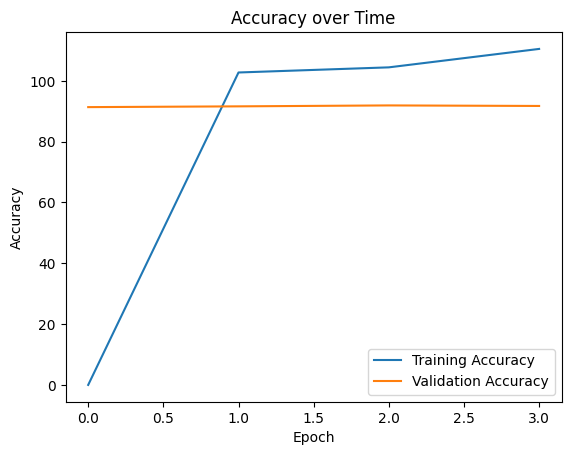

In [12]:
# Plot the accuracy graph
plt.plot(accuracy_values, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Time')
plt.legend()
plt.show()

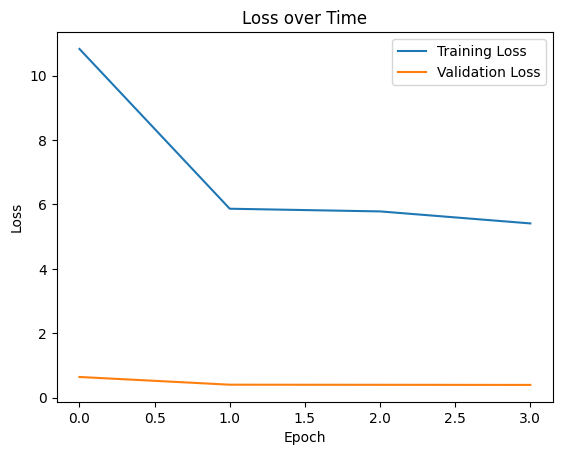

In [13]:
plt.plot(loss_values,  label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Time')
plt.legend()
plt.show()